In [ ]:
# default_exp preprocess.input_fields

# Preprocess Inputs

> API details.

In [ ]:
#hide
from nbdev.showdoc import *
import matplotlib.pyplot as plt

In [ ]:
#export
import os
import pickle

import numpy as np 
from scipy.spatial.distance import cdist

import accelerate_simulations
from accelerate_simulations.geometry import GeometryRasterizer

In [ ]:
#hide
path_project = os.path.join(os.getcwd(), '..')
path_data = os.path.join(path_project, 'data', 'raw', '1', 'abstract_geometry.pickle')

In [ ]:
#hide
with open(path_data, 'rb') as file:
    abstract_geometry = pickle.load(file)

In [ ]:
#hide
geometry_rasterizer = GeometryRasterizer(abstract_geometry)
geometry_rasterizer.rasterize()

In [ ]:
#hide
names_boundary = [
    'boundary_left',
    'boundary_bot',
    'boundary_right',
    'boundary_top',
    'circle_boundary']

names_domains = ['holes', 'box_wo_holes']

In [ ]:
#export
class MaterialFieldMaker:
    def __init__(self, geometry_rasterizer: GeometryRasterizer, material_properties):
        self.elements = geometry_rasterizer.elements
        self.x, self.y, self.labels_fields = geometry_rasterizer.get_label_fields()
        self.material_properties = material_properties

    def __call__(self):
        material_fields = []
        for properties in self.material_properties.values():
            material_field = np.zeros_like(self.labels_fields)
            for name, value in properties.items():
                label = self.elements[name][0]
                cond = (self.labels_fields == label)
                material_field[cond] = value
                
            material_fields.append(material_field)
        return np.stack(material_fields, axis=-1)

In [ ]:
material_properties = {
    'y': {'box_wo_holes': 10, 'holes': 1},
    'b': {'box_wo_holes': 100, 'holes': 100}
}

make_material_fields = MaterialFieldMaker(geometry_rasterizer, material_properties)
material_fields = make_material_fields()
material_fields.shape

(100, 100, 2)

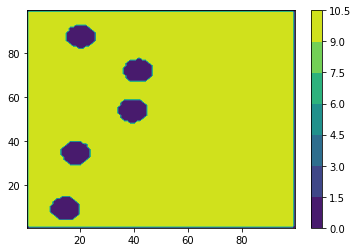

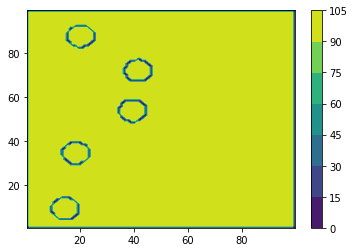

In [ ]:
for i in range(material_fields.shape[2]):
    plt.figure()
    grid_x, grid_y = np.meshgrid(make_material_fields.x, make_material_fields.y)
    plt.contourf(grid_x, grid_y, material_fields[:, :, i])
    plt.colorbar()

In [ ]:
#export
class GeometricFieldMaker:
    def __init__(self, geometry_rasterizer: GeometryRasterizer, names_boundary, scaling_factor):
        geometry_rasterizer.rasterize()
        self.elements = geometry_rasterizer.elements
        self.x, self.y, self.labels_fields = geometry_rasterizer.get_label_fields()
        self.names_boundary = names_boundary
        self.scaling_factor = scaling_factor

    def __call__(self):
        geometric_fields = []
        for name in self.names_boundary:
            label = self.elements[name][0]
            grid_flat, grid_flat_some = self._get_grid(self.x, self.y, label)
            geometric_field = self._make_geometric_field(grid_flat, grid_flat_some)
            geometric_field = geometric_field.reshape(len(self.x), len(self.y))
            geometric_fields.append(geometric_field)
        
        return np.stack(geometric_fields, axis=-1)

    def _get_grid(self, x, y, label_field):
        grid_x, grid_y = np.meshgrid(x, y)

        cond = (self.labels_fields==label_field)
        grid_x_some = grid_x[cond]
        grid_y_some = grid_y[cond]

        grid_flat = np.hstack([grid_x.flatten()[:, None], grid_y.flatten()[:, None]])
        grid_flat_some = np.hstack([grid_x_some.flatten()[:, None], grid_y_some.flatten()[:, None]])

        return grid_flat, grid_flat_some

    def _dist_radial(self, x):
        return np.exp(-self.scaling_factor * x/(x.max()+1e-8))

    def _make_geometric_field(self, grid_flat, grid_flat_some):
        dist_point_to_boundary = cdist(grid_flat, grid_flat_some)
        dist_point_to_boundary = np.min(dist_point_to_boundary, axis=1)
        return self._dist_radial(dist_point_to_boundary)

In [ ]:
make_geometric_fields = GeometricFieldMaker(geometry_rasterizer, names_boundary, scaling_factor=1)
geometric_fields = make_geometric_fields()

In [ ]:
# material_fields = []
# for properties in material_properties.values():
#     material_field = np.zeros_like(make_material_fields.labels_fields)
#     for name, value in properties.items():
#         print(material_field.shape)
#         print(name)
#         label = make_material_fields.elements[name][0]
#         print(label)
#         cond = (make_material_fields.labels_fields == label)
#         print(cond.shape)
#         material_field[cond] = value
#         print(material_field[cond])
#     material_fields.append(material_fields)

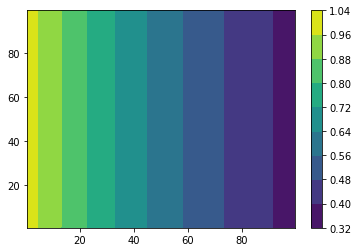

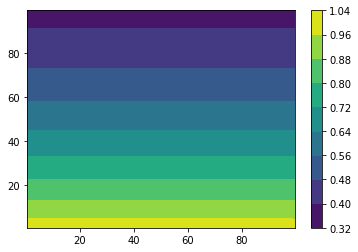

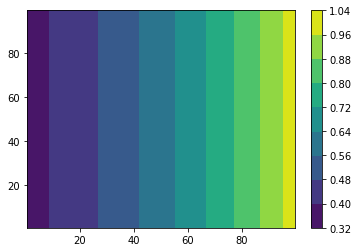

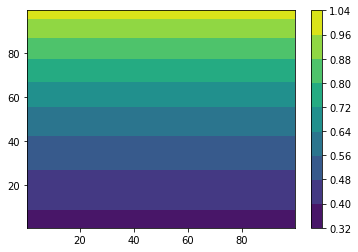

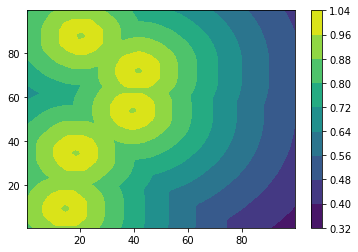

In [ ]:
for i in range(geometric_fields.shape[2]):
    plt.figure()
    grid_x, grid_y = np.meshgrid(make_geometric_fields.x, make_geometric_fields.y)
    plt.contourf(grid_x, grid_y, geometric_fields[:, :, i])
    plt.colorbar()